# 📌 Introduction
This project focuses on building and evaluating machine learning classifiers to predict a binary target in an imbalanced dataset. The goal is to compare several models — including Logistic Regression, Decision Tree, Random Forest, K-Nearest Neighbors, Support Vector Machine (SVM), and XGBoost — and identify the best-performing one in terms of accuracy and F1 score.

Special attention is given to:

1. Handling *class imbalance*

2. Hyperparameter tuning using *RandomizedSearchCV*.

3. Model evaluation using *confusion matrix, classification report, and stratified k-fold cross-validation, roc auc curve*

4. Final model selection based on business trade-offs between precision, recall, and F1 score.

The project is designed to demonstrate not just technical implementation, but also practical decision-making in model selection.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
import pandas as pd

zip_path = '/content/archive (1).zip' # /archive (1).zip

with zipfile.ZipFile(zip_path) as z:
    # Open the specific file you want
    with z.open('bank/bank-full.csv') as f:
        df = pd.read_csv(f, sep=';')  # sep=';' is common for this dataset

df = pd.DataFrame(df)
pd.set_option('display.max_columns', None)
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Let's clarify some columns unclear to better understand the nature of data we have

1. **default**: has credit in default? (binary: "yes","no")
2.  **balance**: average yearly balance, in euros (numeric)
3.  **housing**: has housing loan? (binary: "yes","no")
4. **contact**: contact communication type (categorical: "unknown","telephone","cellular")
5. **day**: last contact day of the month (numeric)
6. **month**: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
7. **duration**: last contact duration, in seconds (numeric)
8.  **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
9. **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
10. **previous**: number of contacts performed before this campaign and for this client (numeric)
11. **poutcome**: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

*Target Variable* - *y*
has the client subscribed a term deposit? (binary: "yes","no") - we will predict this binary classification by training our model

In [4]:
df.shape

(45211, 17)

# Feature Names and its Datatypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Look like we dont have any *Null values* in our dataset

Our DataFrame shape is *(45211, 17)* and df.info() shows that all 17 columns have 45211 non-null entries,

# Descriptive Analysis
In descriptive Analysis we analysis each variable separately to get inference about the feature.

*Summary satistics of Numerical Features*

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


### Summary statistics of Categorical features

In [7]:
df.describe(include='object').transpose()

,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959
y,45211,2,no,39922


⚠️ What this tells us:

1. *Imbalanced Target*:
The target variable y has only 11.8% "yes" values
2. *Dominant Categories*:
Some categories dominate (default = no, loan = no, poutcome = unknown, etc.).
3. *Possible Feature Engineering Ideas*:
- Group less frequent job types (e.g., combine rare ones into “other”).
- Convert month to numerical column datatype

### Variance of each numerical features

In [8]:
df.select_dtypes(include=['int64']).var()

,0
age,1.127581e+02
balance,9.270599e+06
day,6.926361e+01
duration,6.632057e+04
campaign,9.597733e+00
pdays,1.002577e+04
previous,5.305841e+00


*balance* and *duration* have high variance - they might have outliers.

### Skew in numerical features

In [9]:
df.select_dtypes(include=['int64']).skew()

,0
age,0.684818
balance,8.360308
day,0.093079
duration,3.144318
campaign,4.898650
pdays,2.615715
previous,41.846454


All numeric cols except *age* and *day* are  highly positively skewed, especially *previous*

# Exploratory Data Analysis and Visualization

### Histograms
To find the distributions and outlier in the each feature

<Figure size 1500x600 with 0 Axes>

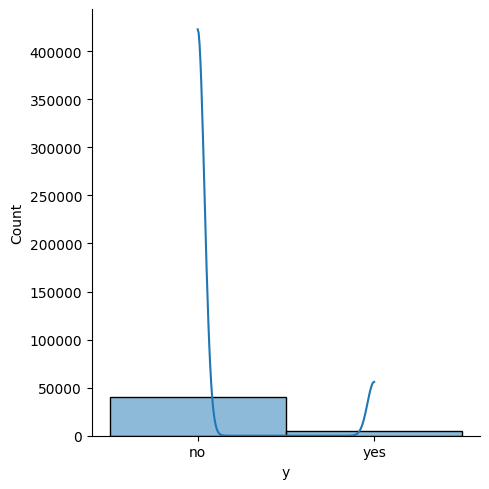

In [10]:
plt.figure(figsize=(15,6))
sns.displot(df['y'], kde=True)
plt.show()

The *no* class (clients who did not subscribe) is overwhelmingly dominant.

The *yes* class (clients who did subscribe) is a very small minority.

This is a big problem. Because, if the number of data points in minority class is much less, then it may end up being completely ignored during training.

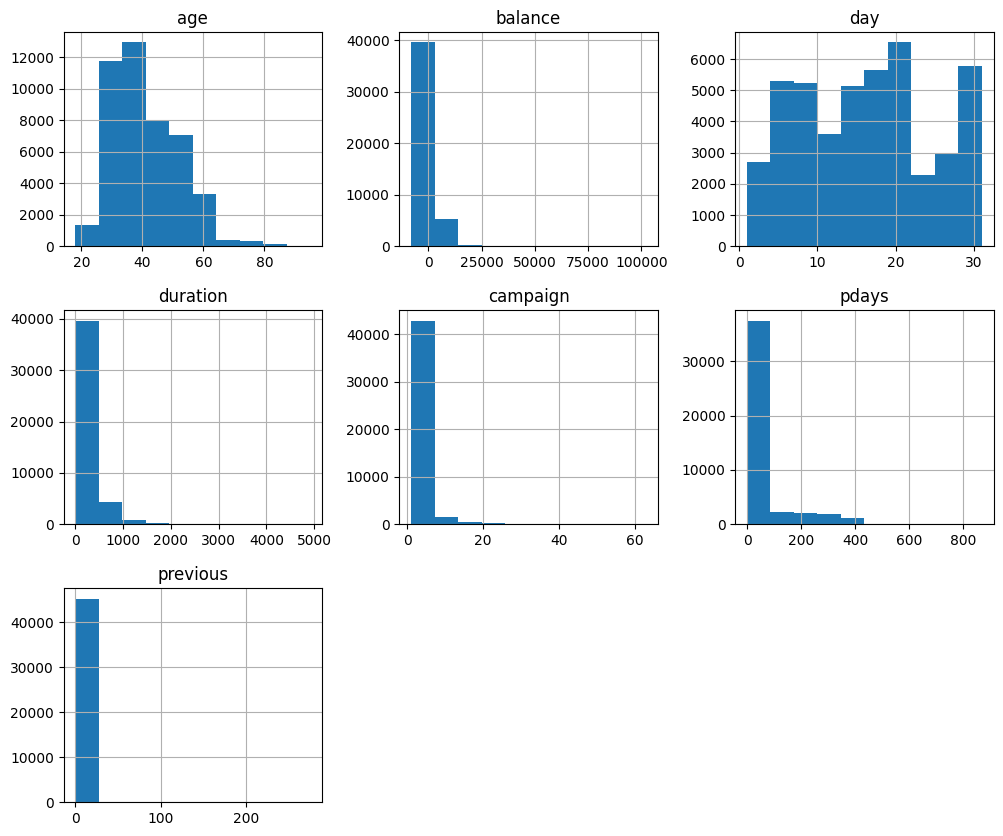

In [11]:
df.hist(figsize=(12,10))
plt.show()

### Number Unique values in each feature

In [12]:
df.nunique()

,0
age,77
job,12
marital,3
education,4
default,2
balance,7168
housing,2
loan,2
contact,3
day,31


*balance* and *duration* cols have a reasonably the most number on unique values`

### Missing Values

In [13]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


Thanks for the dataset, we dont have any Missing Values

### Barplot of unique value counts in every categorical features

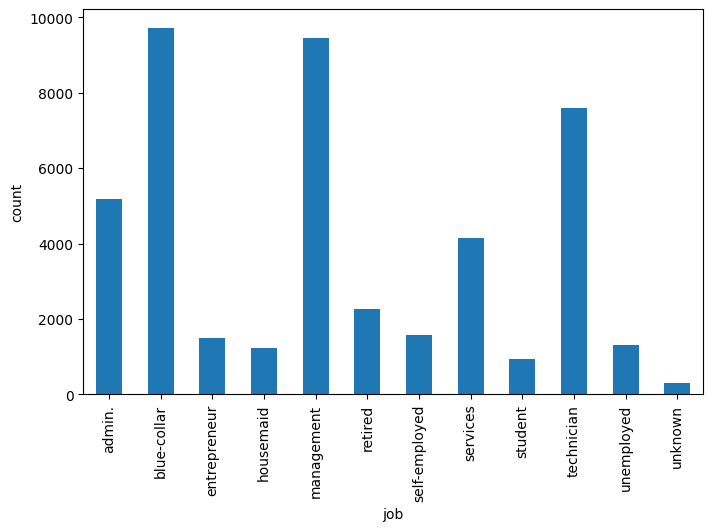

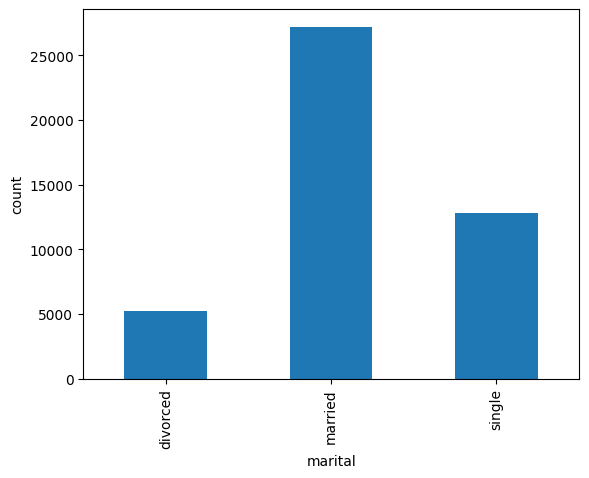

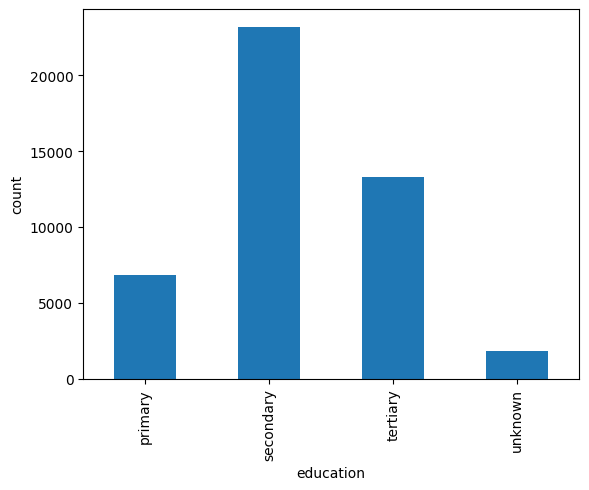

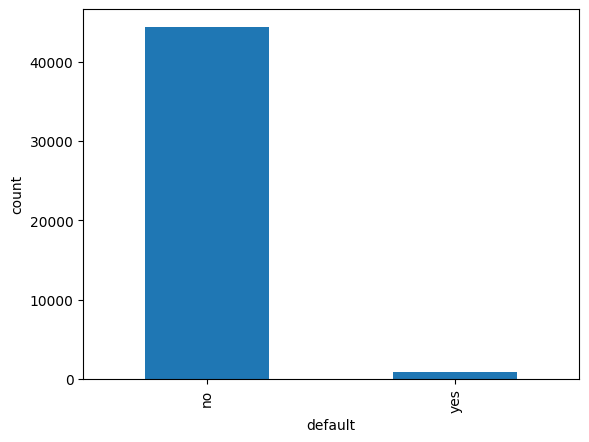

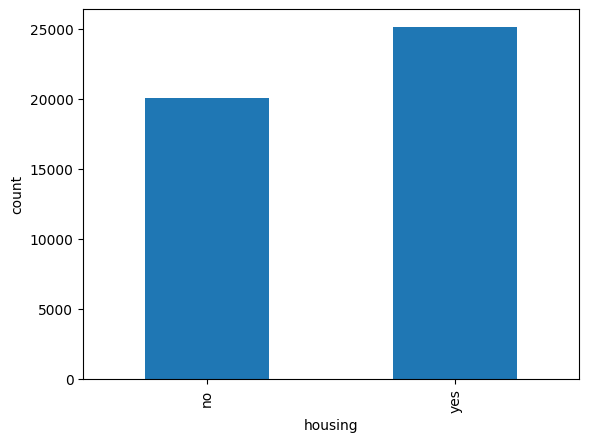

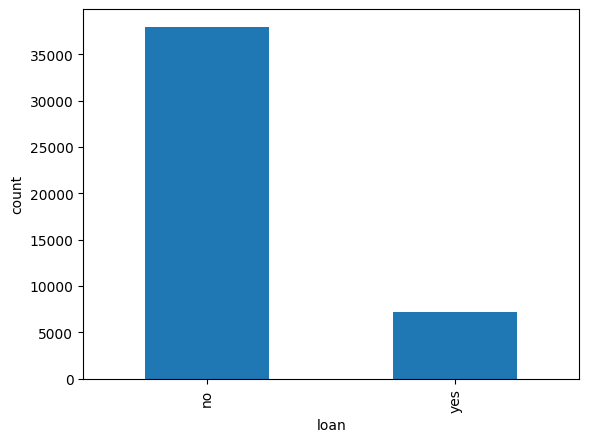

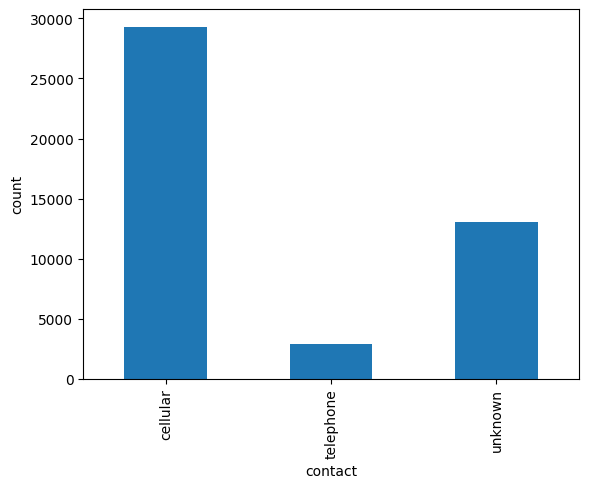

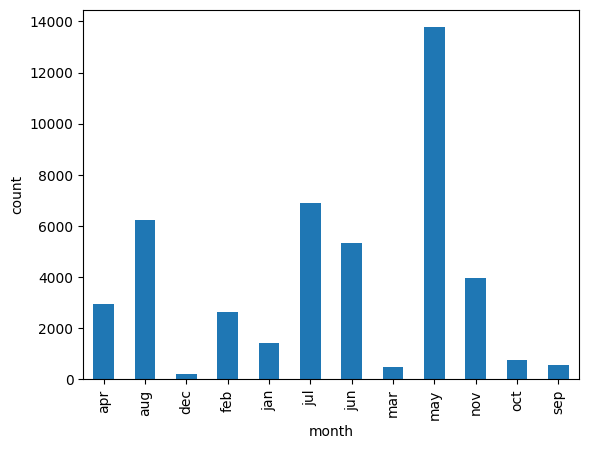

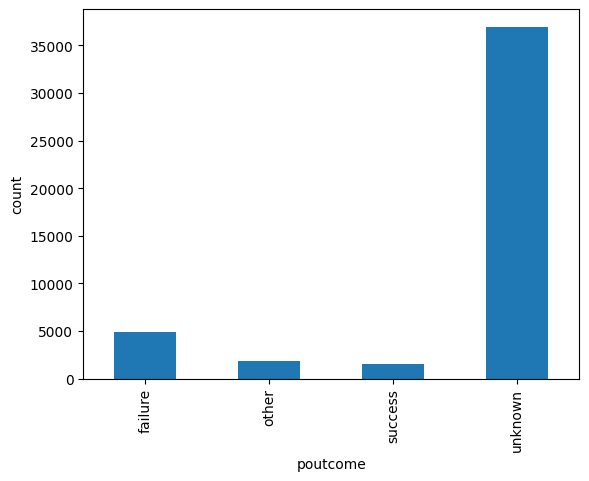

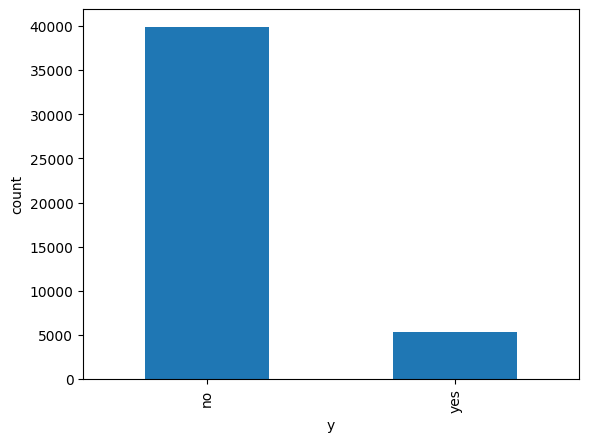

In [14]:
categ_cols = df.select_dtypes(include='object').columns.tolist()

plt.figure(figsize=(8,5))

for col in categ_cols:
  df[col].value_counts().sort_index().plot(kind='bar',xlabel=col, ylabel='count')
  plt.show()

In [15]:
# creating a temp df for correlation
df_temp = df.copy()
# This will convert all 'yes' values to 1 and 'no' values to 0
df_temp['y'] = df_temp['y'].replace({'yes':1, 'no':0})

corr= df_temp.corr(numeric_only=True)
target_corr = corr['y']
target_corr = target_corr.sort_values(ascending=False).drop('y')

target_corr

/tmp/ipython-input-15-1131784594.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp['y'] = df_temp['y'].replace({'yes':1, 'no':0})


,y
duration,0.394521
pdays,0.103621
previous,0.093236
balance,0.052838
age,0.025155
day,-0.028348
campaign,-0.073172


So, duration( last contact duration, in seconds)is the most positively correlated numeric col to target variable

campaign - is the by fat the least numeric col

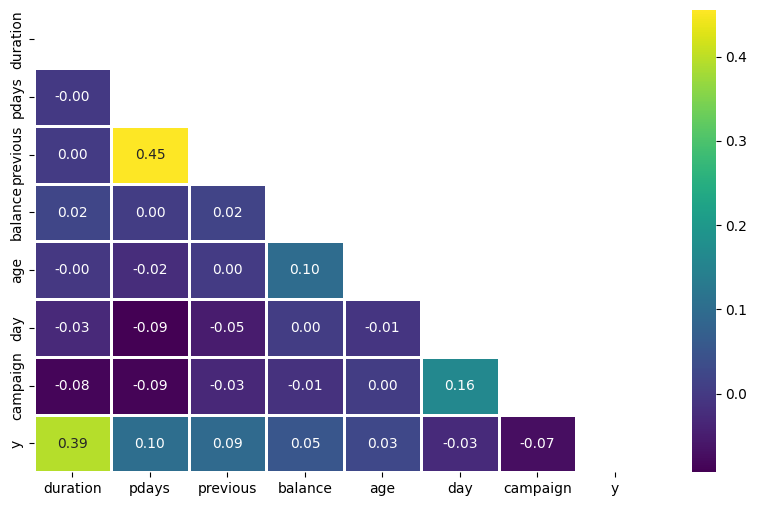

In [16]:
# Get list of features to include in heatmap (including y)
features = target_corr.index.tolist() + ['y']
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a smaller correlation matrix for just these features
filtered_corr = df_temp[features].corr()

plt.figure(figsize=(10,6))
sns.heatmap(filtered_corr, annot=True,cmap="viridis", fmt=".2f", linewidths=1,mask=mask)
plt.show()

### Barplot of unique value counts in every categorical features

### Boxplots for Categorical Features

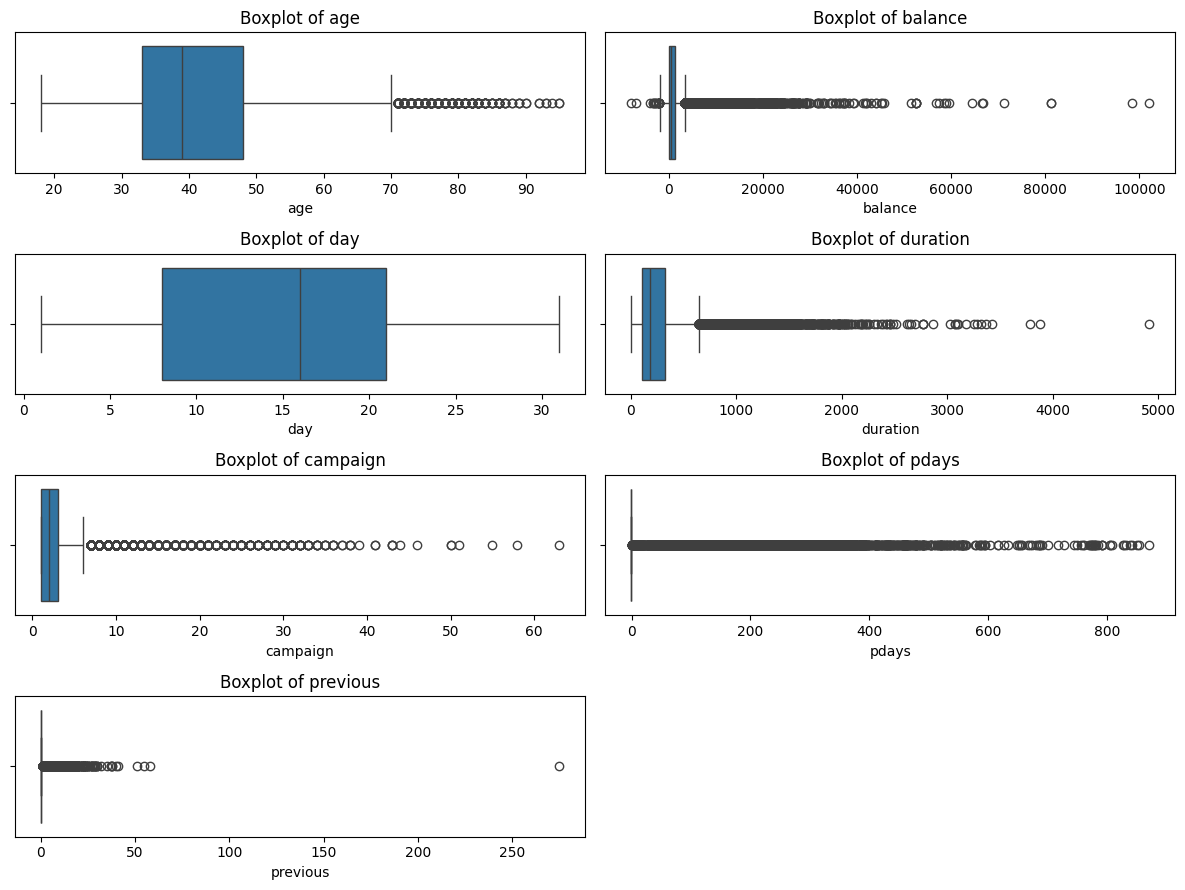

In [17]:
numeric_cols = df.select_dtypes(include=['int64']).columns

plt.figure(figsize=(12, 9))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 2, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Boxplots visually show distribution, skewness, and outliers

1. *previous, campaign, pdays, duration and balance* are Highly positively skewed. and have Many extreme outliers
2. *day and age* are almost uniformly distributed compared to mentioned columns

### Density plots of numerical features

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

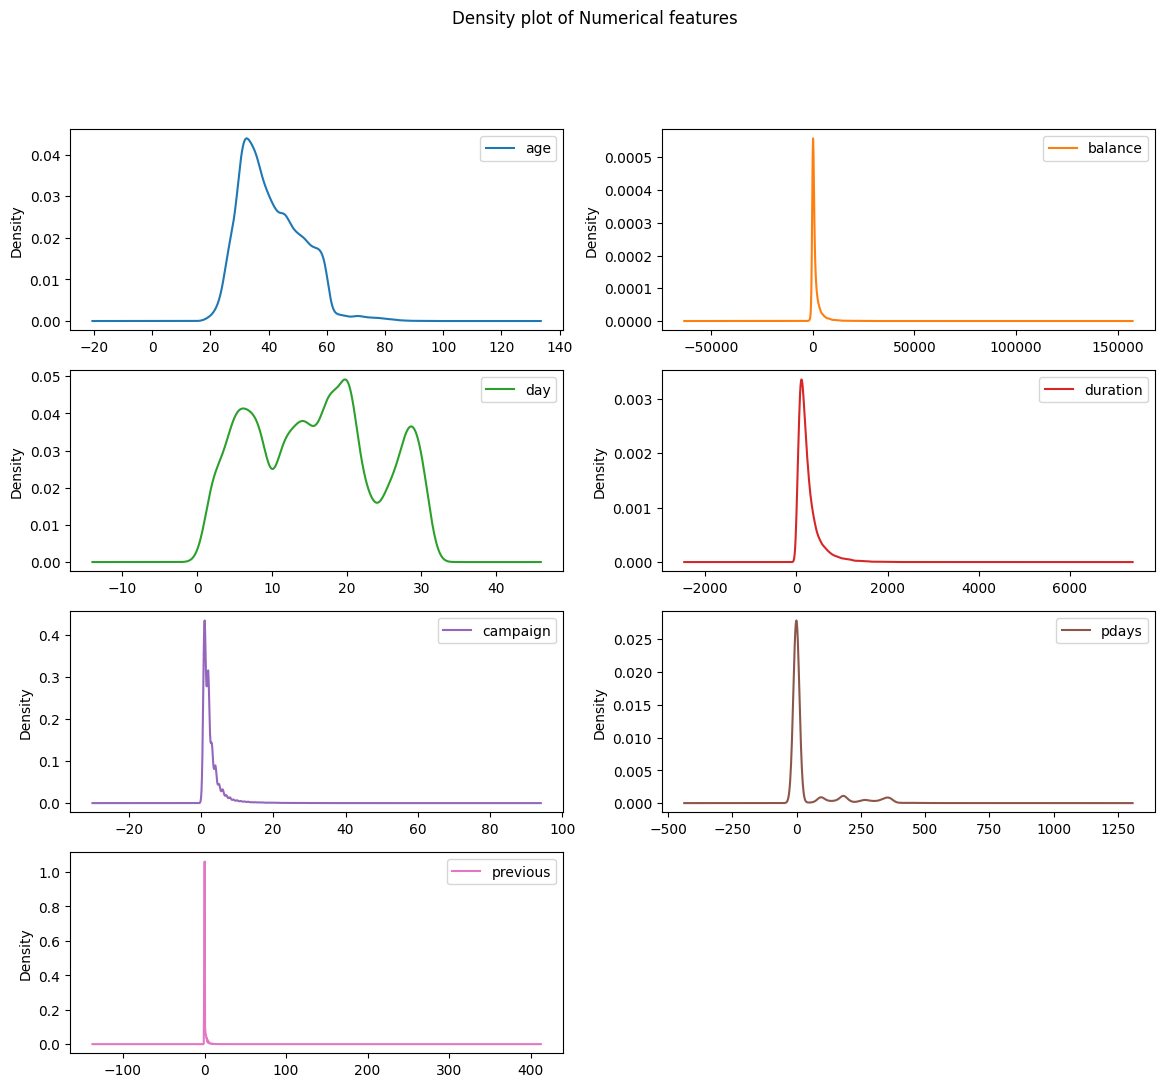

In [18]:
df.plot(kind='density', figsize=(14,12), subplots=True, layout=(4,2), title="Density plot of Numerical features",sharex=False)

#  Feature Engineering and Data Preprocessing

Feature engineering is the process of selecting, manipulating and transforming raw data into features that can be used in supervised learning. It’s also necessary to design and train new machine learning features so it can tackle new tasks

### Log transformation

Common technique for preprocessing data before applying it to machine learning models

Log transformation helps by:

1. Making the data more symmetrical (normal-shaped).
2. Making patterns between variables clearer.
3. Making predictions more stable and reliable.(removing heteroscedasticity)
4. Reducing the effect of extreme values (outliers).

In [19]:
df.select_dtypes(include=['int64']).skew().sort_values(ascending=False)

,0
previous,41.846454
balance,8.360308
campaign,4.898650
duration,3.144318
pdays,2.615715
age,0.684818
day,0.093079


Out of 7 numerical cols we have 5 of them with a high positive skewness, so we can apply log transformation to them

We use **log transformation** when:

Some numbers are extremely large compared to others.

Data is not following a normal (bell-shaped) distribution.

In [20]:
skewed_cols = ['previous', 'campaign', 'duration'] # we removed balance col

for col in skewed_cols:
  df[col] = np.log1p(df[col])
  print(f'min value of {col} is {df[col].min()}')

min value of previous is 0.0
min value of campaign is 0.6931471805599453
min value of duration is 0.0


We have a minimum value of *balance* is *-inf*,(to see it just add *balance* in *skewed_cols* list and run code again) meaning we cant use log or log1p with this column

We will use The **Yeo-Johnson transformation**

An extension of the Box-Cox method, serves to stabilize variance and normalize data distributions, rendering it more adaptable for real-world scenarios by accommodating both positive and negative data values.

In [21]:
from sklearn.preprocessing import PowerTransformer

In [22]:
# Initialize the PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df['balance'] = pt.fit_transform(df[['balance']])

For *pdays* col since it has a negative value,we will add a flag column for *pdays* so we don’t lose information, because numpy.log() function is only defined for positive real numbers, and will raise a ValueError if given a non-positive number.


In [23]:
# True where pdays == -1, else False.
df['pdays_missing_bool'] = (df['pdays']==-1).astype(int) # .astype(int) converts True → 1 and False → 0.

-1 means the client was never contacted before, so if it's true we assing in the new feauture as 1

in the *pdays_missing_bool* :     
*0* - the client was contacted before

*1* - the client was not contacted before (original pdays = -1)

Now we can replace -1 with 0 in *pdays* col and we'll apply log1p, which computes log(1 + x) — and log1p(0) is safe (= 0).

In [24]:
df['pdays'] = df['pdays'].replace(-1,0)
df['pdays'] = np.log1p(df['pdays'])

df.describe()

,age,balance,day,duration,campaign,pdays,previous,pdays_missing_bool
count,45211.000000,4.521100e+04,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,-1.508750e-17,15.806419,5.171812,1.158564,0.956843,0.226365,0.817367
std,10.618762,1.000011e+00,8.322476,0.921822,0.511758,2.047562,0.533111,0.386369
min,18.000000,-3.487951e+01,1.000000,0.000000,0.693147,0.000000,0.000000,0.000000
25%,33.000000,-3.844520e-01,8.000000,4.644391,0.693147,0.000000,0.000000,1.000000
50%,39.000000,-2.051635e-01,16.000000,5.198497,1.098612,0.000000,0.000000,1.000000
75%,48.000000,1.701684e-01,21.000000,5.768321,1.386294,0.000000,0.000000,1.000000
max,95.000000,2.113694e+01,31.000000,8.500861,4.158883,6.770789,5.620401,1.000000


All columns now have sane distributions and scale.

# Train & Test Datasets
Now, we want to create our train and test partitions. Use scikit-learn to split up X and y into a training set and test set. Set the test proportion to 20% of the total population. To get the same data split as the solutions notebook, you can specify random_state = 77.

In [25]:
from sklearn.model_selection import train_test_split

We need to separate out the data into X - features and Y - label

In [26]:
X = df.drop(columns=['y'])
y = df['y']

Now can split our data into train and test datasets

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=77)

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (36168, 17)
x_test shape: (9043, 17)


# One-hot Encoding
One-hot encoding is a technique for representing categorical data as numerical vectors, where each unique category is represented by a binary column

In [28]:
x_train.select_dtypes(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome
18900,technician,married,secondary,no,no,no,unknown,aug,unknown
2406,management,married,primary,no,yes,no,unknown,may,unknown
36346,self-employed,single,tertiary,no,yes,no,cellular,may,failure
40372,entrepreneur,single,secondary,no,no,no,cellular,jun,unknown
30695,entrepreneur,married,secondary,no,no,no,cellular,feb,unknown
...,...,...,...,...,...,...,...,...,...
25503,management,married,tertiary,no,yes,no,cellular,nov,failure
7832,technician,married,secondary,no,yes,no,unknown,may,unknown
42277,technician,divorced,secondary,no,no,no,cellular,nov,success
18667,management,single,tertiary,no,no,no,telephone,jul,unknown


You can see we have categorical columns so we need to transforms categorical data into a format(binary) that machine learning models can easily understand and use

In [29]:
x_train.job.unique()

array(['technician', 'management', 'self-employed', 'entrepreneur',
       'admin.', 'blue-collar', 'retired', 'services', 'housemaid',
       'student', 'unknown', 'unemployed'], dtype=object)

For example, in *job* column we have 12 types of jobs, so using One-hot Encoding will transform categorical values to numeric

In [30]:
categ_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=['int64']).columns.tolist()

categ_cols = categ_cols[:-1] # removing our target col
categ_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

Rather than managing every step individually - scaling, one-hot encoding, we can use **Pipeline**

A *Machine Learning Pipeline* is a systematic workflow designed to automate the process of building, training and evaluating of ML models. It includes several steps, such as data collection, preprocessing, feature engineering, model training, evaluation

Benefits of Machine Learning pipeline ⏩:
1. *Handles Large Data easily*
2.  *Cost-Effective*: Machine Learning Pipeline saves time and money by automating tasks that would normally require manual work.
3.  *Improve Accuracy & Consistency*: It ensures that data is processed the same way every time reducing human error and making predictions more reliable.
4. *Automation and Efficiency*: It automates the repetitive tasks such as data cleaning, model training and testing. It saves time and speeds up the development process

###  Preprocessing Pipeline

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

We will use *Standardization* in favor of *Min-Max Scaling*, because:

1. We applied lop1p and will apply yeo-johnson for handling imbalanced data - which helps normalize skewed features
2. Better for data which is already normally distributed

In [32]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categ_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine num_transformer  and categ_transformer
preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('categ', categ_transformer, categ_cols)
])

In [33]:
x_train_prep = preprocessor.fit_transform(x_train)
x_test_prep = preprocessor.transform(x_test)

In [34]:
x_train_prep

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 434016 stored elements and shape (36168, 47)>

**Compressed Sparse Row (CSR):**
A memory-efficient format for storing data that contains a lot of zeros.

before transforming our trand and test data, we should not forget about class imbalance in our target variable *y*, where:

In [35]:
df['y'].value_counts(normalize=True)

,proportion
y,
no,0.883015
yes,0.116985


We will use **Synthetic Minority Over-Sampling Technique** (*SMOTE*) - is a powerful method used to handle class imbalance in datasets. SMOTE handles this issue by generating samples of minority classes to make the class distribution balanced.



In [36]:
from imblearn.over_sampling import SMOTE

In [37]:
smote = SMOTE(sampling_strategy='minority', random_state=77) # generating synthetic samples for the minority class
X_train, y_train_ = smote.fit_resample(x_train_prep, y_train)

# Training models
## Logistic Regression
Logistic regression is a supervised machine learning algorithm that accomplishes binary classification tasks by predicting the probability of an outcome, event, or observation.

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
lgr = LogisticRegression(
    penalty='l2',
    C=1,
    solver='liblinear',
    random_state=77,
    max_iter=1000
)

lgr.fit(X_train,y_train_)

LogisticRegression(C=1, max_iter=1000, random_state=77, solver='liblinear')

In [40]:
lgr_y_pred = lgr.predict(x_test_prep)

#  Evaluation of Logistic Regression Model

### Compute Classification Report and Confusion Matrix
Classification Report and Confusion Matrix are used to check machine learning model's performance during model development. These help us understand the accuracy of predictions and tells areas of improvement.

- The **Classification Report** summarizes the performance of a classification model. It includes key metrics such as:

*Precision* : Measures the accuracy of positive predictions.

*Recall* : Indicates how many actual positives were correctly identified.

*F1-Score* : Balances precision and recall into a single score.

*Support* : Shows the number of samples for each class.

- **Confusion Matrix** is a table that compares the model's predictions against the actual values. It highlights where the model succeeds and where it makes mistakes.

*True Positive (TP):* The model correctly predicted a positive outcome i.e the actual outcome was positive.

*True Negative (TN)*: The model correctly predicted a negative outcome i.e the actual outcome was negative

*False Positive (FP):* The model incorrectly predicted a positive outcome i.e the actual outcome was negative. It is also known as a Type I error

*False Negative (FN):* The model incorrectly predicted a negative outcome i.e the actual outcome was positive. It is also known as a Type II error.

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

print(f'Classification Report: {classification_report(y_test,lgr_y_pred)}')
print(f'Confusion Matrix: {confusion_matrix(y_test, lgr_y_pred)}')

Classification Report:               precision    recall  f1-score   support

          no       0.94      0.76      0.84      7976
         yes       0.26      0.63      0.37      1067

    accuracy                           0.75      9043
   macro avg       0.60      0.70      0.61      9043
weighted avg       0.86      0.75      0.79      9043

Confusion Matrix: [[6081 1895]
 [ 396  671]]


Our model leans towards predicting the majority class - "no". While it's good at identifying the "no" instances, it makes a lot of **False Positive errors** when predicting "yes", meaning it frequently predicts "yes" when the true label is "no

We can plot confusion matrix

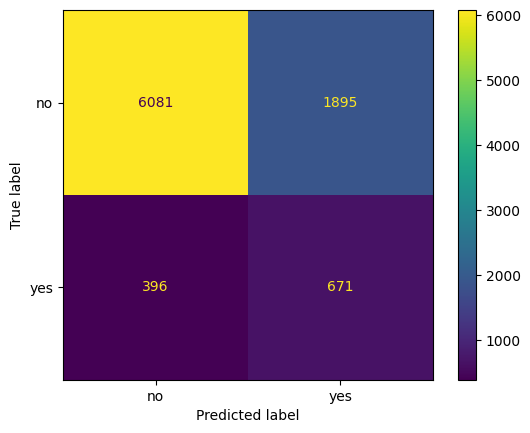

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, lgr_y_pred, labels=lgr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgr.classes_)

disp.plot()
plt.show()

In [43]:
from sklearn import metrics
print(f"Logistic Regression model accuracy:{metrics.accuracy_score(y_test, lgr_y_pred) * 100:.2f}%")

Logistic Regression model accuracy:74.67%


We can create def fucntion to evaluate our model

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy {accuracy_score(y_test, y_pred)}")

    # Automatically choose pos_label depending on label type
    if y_test.dtype == 'object':
        pos = 'yes'
    else:
        pos = 1

    print(f"F1 Score {f1_score(y_test, y_pred, pos_label=pos)}")
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


### Hyperparameter Tuning with RandomizedSearchCV

In [45]:
from sklearn.model_selection import RandomizedSearchCV

In [46]:
param_grid = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver' : ['liblinear', 'saga'],
    'max_iter' : [100,300,500,700,1000]
}

lgr_cw = LogisticRegression(class_weight='balanced', random_state=77)

rs_lgr = RandomizedSearchCV(
    estimator = lgr_cw,
    param_distributions = param_grid,
    cv=5,
    scoring='f1', # We often use F1 score when the classes are imbalanced
    verbose=1,
    n_jobs=-1
)

In [47]:
rs_lgr.fit(X_train,y_train_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(class_weight='balanced',
                                                random_state=77),
                   n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'max_iter': [100, 300, 500, 700, 1000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   scoring='f1', verbose=1)

In [48]:
best_params = rs_lgr.best_params_
best_params

{'solver': 'saga', 'penalty': 'l2', 'max_iter': 300, 'C': 10}

In [49]:
best_lgr = LogisticRegression(**best_params, random_state=77)
best_lgr.fit(X_train, y_train_)

LogisticRegression(C=10, max_iter=300, random_state=77, solver='saga')

In [50]:
best_lgr_y_pred = best_lgr.predict(x_test_prep)

### The ROC AUC score

It measures how well a model distinguishes between the two classes it's trying to classify.

- A perfect classifier has an AUC of 1.0.
- A random classifier (guessing) has an AUC of 0.5.
- AUC values between 0.7 and 0.8 are generally considered acceptable, 0.8 to 0.9 excellent, and above 0.9 outstanding

The higher the AUC score, the better the classifier's ability to distinguish between the classes.

In [51]:
# We can use sklearn to easily calculate the ROC AUC
from sklearn.metrics import roc_auc_score

In [52]:
best_lgr_y_prob = best_lgr.predict_proba(x_test_prep)[:, 1]
roc_auc = roc_auc_score(y_test, best_lgr_y_prob)

print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.7628


### Plotting the ROC Curve

In [53]:
from sklearn.metrics import roc_curve, RocCurveDisplay

In [54]:
def roc_plot(y_test, y_pred):
  fpr, tpr, _ = roc_curve(y_test, y_pred)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, pos_label='yes').plot()
  roc_display.figure_.set_size_inches(5,5)
  plt.plot([0,1], [0,1], color='g') # Plot a diagonal reference line and Represents a random guessing classifier

In [55]:
y_test_binary = y_test.map({'no':0, 'yes':1}) # for roc curve we need binary values

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


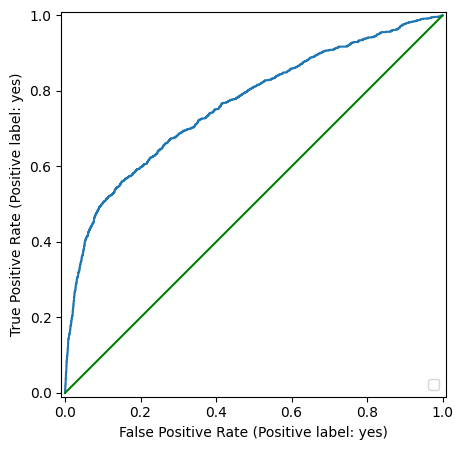

In [56]:
roc_plot(y_test_binary, best_lgr_y_prob)

Classifiers that give curves closer to the **top-left** corner indicate a *better performance*

The closer the curve comes to the 45-degree diagonal of the ROC space, indicate a *worse performance*

In [57]:
evaluate_model(best_lgr, X_train, y_train_, x_test_prep, y_test)

Model: LogisticRegression
Accuracy 0.7467654539422758
F1 Score 0.3694933920704846
Classification report:
              precision    recall  f1-score   support

          no       0.94      0.76      0.84      7976
         yes       0.26      0.63      0.37      1067

    accuracy                           0.75      9043
   macro avg       0.60      0.70      0.61      9043
weighted avg       0.86      0.75      0.79      9043

Confusion Matrix:
[[6082 1894]
 [ 396  671]]


The Model Didn't Improve Much:

Even after tuning, Logistic Regression has limits:

1. Cannot capture nonlinear relationships or interactions unless explicitly engineered.

2. Suffers when classes are imbalanced, even with SMOTE.

3. Performance plateaus quickly, even after tuning hyperparameters.

We're in a great position to try more flexible models like:

Decision Tree Classifier

Random Forest Classifier

KNN

SVM

XGBoost

# Decision Tree Classifier

In [58]:
from sklearn.tree import DecisionTreeClassifier

In [59]:
dtc = DecisionTreeClassifier(criterion='gini', class_weight='balanced',random_state=77)
dtc.fit(X_train, y_train_)

DecisionTreeClassifier(class_weight='balanced', random_state=77)

In [60]:
dtc_y_pred = dtc.predict(x_test_prep)
dtc_y_prob = dtc.predict_proba(x_test_prep)[:,1]

Evaluate model

In [61]:
evaluate_model(dtc, X_train, y_train_, x_test_prep, y_test)

Model: DecisionTreeClassifier
Accuracy 0.8284861218622138
F1 Score 0.33519074153450495
Classification report:
              precision    recall  f1-score   support

          no       0.91      0.89      0.90      7976
         yes       0.31      0.37      0.34      1067

    accuracy                           0.83      9043
   macro avg       0.61      0.63      0.62      9043
weighted avg       0.84      0.83      0.83      9043

Confusion Matrix:
[[7101  875]
 [ 676  391]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


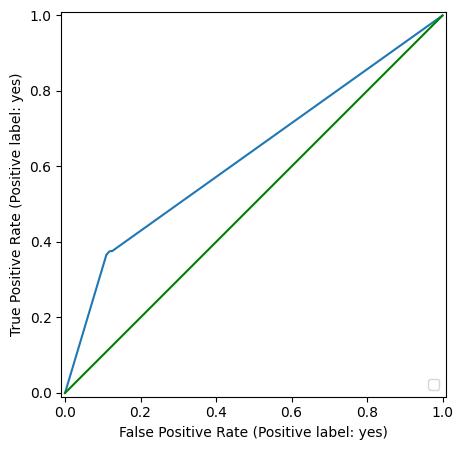

In [62]:
roc_plot(y_test_binary,dtc_y_prob)

### Hyperparameter tuning

Tuning hyperparameters is crucial for decision trees for below reasons:

1. **Improved Performance**: Tuning allows you to find the settings that best suit your data, resulting in a model that captures the underlying patterns more effectively and delivers better predictions.
2. **Reduced Overfitting**: Decision trees are prone to overfitting, where the model memorizes the training data's noise instead of learning generalizable patterns
3. ***Addressing Class Imbalance***(*the most crucial part for our data!*):Tuning hyperparameters like min_weight_fraction_leaf allows you to leverage sample weights and ensure the tree doesn't get biased towards the majority class, leading to more accurate predictions for the minority class.

In [63]:
param_grids = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 5,10,20,30],
    'min_samples_split' : [2,5,10,15,20],
    'min_samples_leaf' : [1,3,5,7,10,13],
    'class_weight' : [None, 'balanced'],
    'max_features' : [None, 'sqrt', 'log2'],
    'min_weight_fraction_leaf' : [0.01, 0.05, 0.1, 0.5]
}

r_dtr = DecisionTreeClassifier(random_state=77)

rcv_dtr =RandomizedSearchCV(
    estimator=r_dtr,
    param_distributions=param_grids,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

In [64]:
rcv_dtr.fit(X_train, y_train_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=77),
                   n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 3, 5, 7, 10,
                                                             13],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'min_weight_fraction_leaf': [0.01, 0.05,
                                                                     0.1,
                                                                     0.5]},
                   scoring='f1', verbose=1)

In [65]:
best_params = rcv_dtr.best_params_
best_params

{'min_weight_fraction_leaf': 0.5,
 'min_samples_split': 5,
 'min_samples_leaf': 7,
 'max_features': None,
 'max_depth': 30,
 'criterion': 'gini',
 'class_weight': None}

In [66]:
best_dtr = DecisionTreeClassifier(**best_params,random_state=77)
best_dtr.fit(X_train, y_train_)

DecisionTreeClassifier(max_depth=30, min_samples_leaf=7, min_samples_split=5,
                       min_weight_fraction_leaf=0.5, random_state=77)

In [67]:
best_dtr_y_pred = best_dtr.predict(x_test_prep)
best_dtr_y_prob = best_dtr.predict_proba(x_test_prep)[:,1]

Evaluate

In [68]:
evaluate_model(best_dtr, X_train, y_train_, x_test_prep, y_test)

Model: DecisionTreeClassifier
Accuracy 0.5194072763463452
F1 Score 0.2028613352898019
Classification report:
              precision    recall  f1-score   support

          no       0.89      0.52      0.66      7976
         yes       0.13      0.52      0.20      1067

    accuracy                           0.52      9043
   macro avg       0.51      0.52      0.43      9043
weighted avg       0.80      0.52      0.60      9043

Confusion Matrix:
[[4144 3832]
 [ 514  553]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


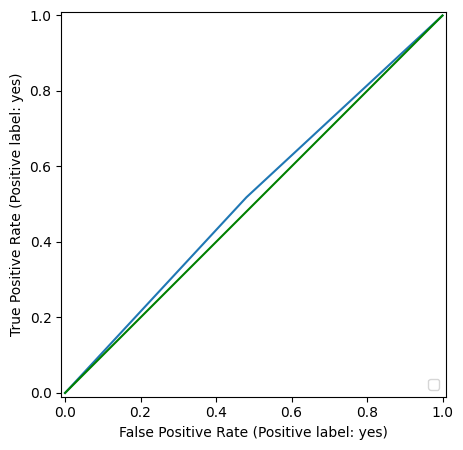

In [69]:
roc_plot(y_test_binary,best_dtr_y_prob)

Our hyperparameters tuned Decision Tree Classifier beats Logistic Regression in

1. *Recall* and *F1 Score* for the "yes" class.

2. Still holds reasonable overall *Accuracy*.

3. ROC Curve plot is more close to the left top corner side =  *indicate a better performance*

Visualize decision-trees with graphviz

In [70]:
import graphviz
from sklearn import tree
import pydotplus

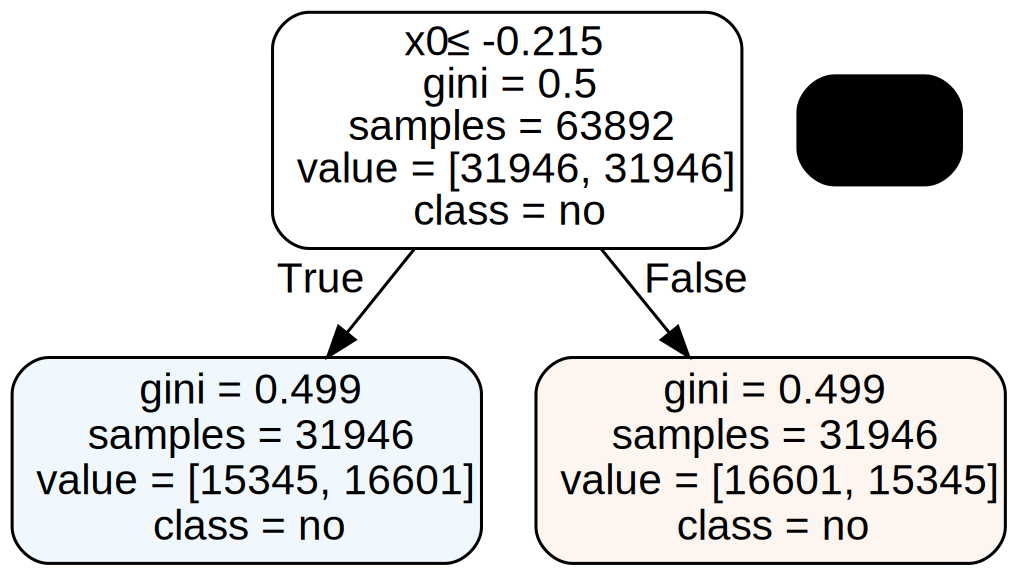

In [71]:
tree_plot = tree.export_graphviz(best_dtr,
                            out_file=None,
                            class_names=y_train_,
                            filled=True,rounded=True,
                            special_characters=True)

pydot_graph = pydotplus.graph_from_dot_data(tree_plot)
pydot_graph.write_png('original_tree.png')
pydot_graph.set_size('"15,8!"')
pydot_graph.write_png('resized_tree.png')

gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

# RandomForestClassifier

In [72]:
from sklearn.ensemble import RandomForestClassifier

Random forest is a supervised learning algorithm

It creates decision trees on the given data samples, gets prediction from each tree and selects the best solution by means of voting.

Random forest algorithm combines multiple decision-trees, resulting in a forest of trees, hence the name Random Forest. In the random forest classifier, the higher the number of trees in the forest results in higher accuracy.

In [73]:
rf = RandomForestClassifier(random_state=77)
rf.fit(X_train, y_train_)

rf_y_pred = rf.predict(x_test_prep)
rf_y_prob = rf.predict_proba(x_test_prep)[:,1]

In [74]:
evaluate_model(rf, X_train, y_train_, x_test_prep, y_test)

Model: RandomForestClassifier
Accuracy 0.862213867079509
F1 Score 0.3694331983805668
Classification report:
              precision    recall  f1-score   support

          no       0.91      0.93      0.92      7976
         yes       0.40      0.34      0.37      1067

    accuracy                           0.86      9043
   macro avg       0.66      0.64      0.65      9043
weighted avg       0.85      0.86      0.86      9043

Confusion Matrix:
[[7432  544]
 [ 702  365]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


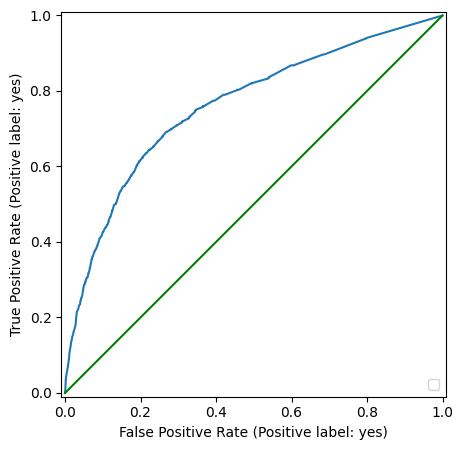

In [75]:
roc_plot(y_test_binary,rf_y_prob)

 Random Forest outperforms Decision Tree on:

*Accuracy* - +**8%**

*Precision* +**15 points**

*F1 Score* +**6 points**

*ROC Curve plot is closer to the top left corner*

To improve our Rnadom Forest Classifier model we will use Hyperparameters Tuning with RandomSearchCV

### Hyperparameter Tuning using RandomizedSearchCV

'criterion' : ['gini',  'entropy'],
    'n_estimators' : [100,200,300,500],
    'max_depth' : [None, 7,10,15,20],
    'min_samples_split' : [2,5,7,10],
    'min_samples_leaf' : [1,2,4,10],
    'max_features' : ['sqrt', 'log2', None]

This wasour original params, but it will probably take 3-5 hours to compute, so we will change params to save time and memory

In [76]:
rrf = RandomForestClassifier(class_weight='balanced', random_state=77)

param_grids_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5,7,10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

rcv_rf = RandomizedSearchCV(
    estimator = rrf,
    param_distributions = param_grids_rf,
    cv = 3,
    n_jobs=-1,
    n_iter=10,
    verbose=1,
    scoring='f1'
)

rcv_rf.fit(X_train, y_train_)

best_params_rf = rcv_rf.best_params_
best_params_rf

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10}

In [77]:
best_rf = RandomForestClassifier(**best_params_rf, random_state=77)
best_rf.fit(X_train, y_train_)

best_rf_y_pred = best_rf.predict(x_test_prep)
best_rf_y_prob = best_rf.predict_proba(x_test_prep)[:,1]

Evaluate Model

In [78]:
evaluate_model(best_rf, X_train, y_train_, x_test_prep, y_test)

Model: RandomForestClassifier
Accuracy 0.830808360057503
F1 Score 0.4370860927152318
Classification report:
              precision    recall  f1-score   support

          no       0.94      0.87      0.90      7976
         yes       0.36      0.56      0.44      1067

    accuracy                           0.83      9043
   macro avg       0.65      0.71      0.67      9043
weighted avg       0.87      0.83      0.85      9043

Confusion Matrix:
[[6919 1057]
 [ 473  594]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


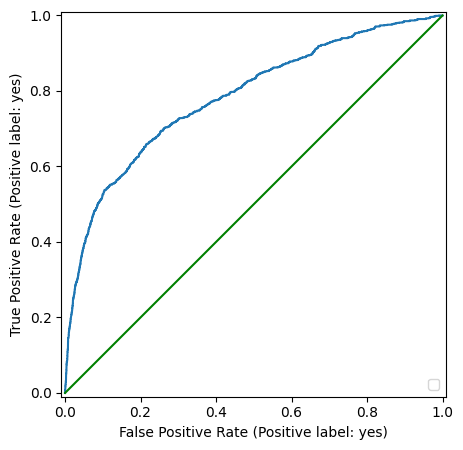

In [79]:
roc_plot(y_test_binary, best_rf_y_prob)

1. We've significantly improved your minority class performance (the hardest part in imbalanced classification).

2. Model now generalizes well and doesn't overfIT

3. If we look closely, our hyperparameter tuned Random Forest Classifier is more close to the left top corner(especially in  the end of diagonal line)


# kNN_Classifier

A k-nearest neighbors is algorithm used for classification and regression. It classifies a new data point by finding the k-nearest points in the training dataset and assigns it the majority class among those neighbors.

### DefaulЕ model

In [81]:
from sklearn.neighbors import KNeighborsClassifier

In [82]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train_)

knn_y_pred = knn.predict(x_test_prep)
knn_y_prob = knn.predict_proba(x_test_prep)[:,1]

Evaluate default KNeighborsClassifier model



In [83]:
evaluate_model(knn, X_train,y_train_, x_test_prep, y_test)

Model: KNeighborsClassifier
Accuracy 0.7542850823841646
F1 Score 0.35556844547563804
Classification report:
              precision    recall  f1-score   support

          no       0.93      0.78      0.85      7976
         yes       0.26      0.57      0.36      1067

    accuracy                           0.75      9043
   macro avg       0.59      0.68      0.60      9043
weighted avg       0.85      0.75      0.79      9043

Confusion Matrix:
[[6208 1768]
 [ 454  613]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


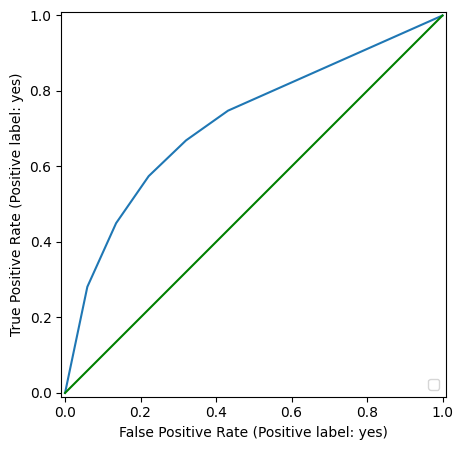

In [84]:
roc_plot(y_test_binary,knn_y_prob)

### Hyperparameter Tuning

In [85]:
rknn = KNeighborsClassifier()

param_grids_knn = {
    "n_neighbors" : np.arange(1,15),
    'weights' : ['uniform', 'distance'],
    'p' : [1,2]
}

rcv_knn = RandomizedSearchCV(
    estimator=rknn,
    param_distributions=param_grids_knn,
    cv=5,
    verbose=1,
    n_jobs=-1,
    scoring='f1'
)

rcv_knn.fit(X_train, y_train_)

best_params_knn = rcv_knn.best_params_
best_params_knn

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'weights': 'distance', 'p': 2, 'n_neighbors': np.int64(2)}

In [86]:
best_knn = KNeighborsClassifier(**best_params_knn)
best_knn.fit(X_train, y_train_)

best_knn_y_pred = best_knn.predict(x_test_prep)
best_knn_y_prob = best_knn.predict_proba(x_test_prep)[:,1]

In [87]:
evaluate_model(best_knn, X_train,y_train_, x_test_prep, y_test)

Model: KNeighborsClassifier
Accuracy 0.8090235541302665
F1 Score 0.3303606048856146
Classification report:
              precision    recall  f1-score   support

          no       0.91      0.86      0.89      7976
         yes       0.28      0.40      0.33      1067

    accuracy                           0.81      9043
   macro avg       0.60      0.63      0.61      9043
weighted avg       0.84      0.81      0.82      9043

Confusion Matrix:
[[6890 1086]
 [ 641  426]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


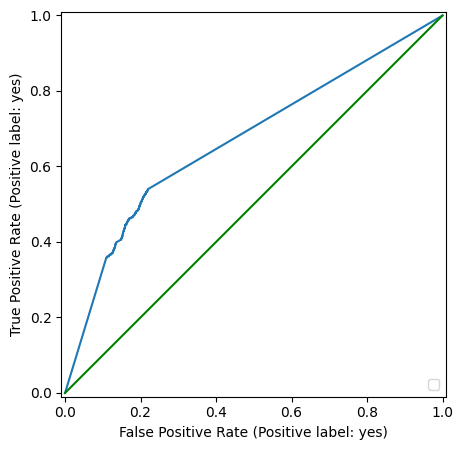

In [88]:
roc_plot(y_test_binary, best_knn_y_prob)

1. *Accuracy* (0.88) is high — but mostly because the model predicts "no" well
2. *Recall* (0.21) for "yes" is very low — it misses most "yes" cases

3. The ROC Curve is quite similar to RandomForest

# Support Vector Machines Classifier

In SVMs, our main objective is to select a hyperplane with the maximum possible margin between support vectors in the given dataset. SVM searches for the maximum margin hyperplane in the following 2 step process –

- Generate hyperplanes which segregates the classes in the best possible way. There are many hyperplanes that might classify the data. We should look for the best hyperplane that represents the largest separation, or margin, between the two classes.

- So, we choose the hyperplane so that distance from it to the support vectors on each side is maximized. If such a hyperplane exists, it is known as the maximum margin hyperplane and the linear classifier it defines is known as a maximum margin classifier.

Consider the below to better understand the concept of SVM

https://www.kaggleusercontent.com/kf/96203833/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..draM7ga00BW5YI6UCkaaIQ.ZBuveQs0XQ4py9yd4pLOxAGAKtKkeFH-tF5r0-Lp3xZdoIX7v7_rRif0dg4z_1TOQPZFU0RL6Y-uRvt4DDjENzWmqEM3e1Q9KPTaDJ7MxrYI4kVNbayi1g_Gdo_v_FPF6qDZV_IPMQnP56ROSAeGUIYYWSXXhOlZNQ7Y5CQdMDx2d8KX2pafnnGYHdEJNCtWxeU6ovouIwxRm4qZrrZq7_FRPiVqiuhE1H7mGdACrlFT8rqTsmONWdD4Y1p5nZ12Rlts6CXA9gaPbERctAWTUmcYlwxXFS6kLFCXLYIRhnscWaVjq_3S1bEYrrcdb-ORFuO2Mj42qOVksYtwSLm6eZ1vWImG9XVLJSqC2aIhCtGrW2RoHpX08G9rflIQAYNsJy82Zr26D-uWV00oY5MiaXbsE1TXHo3Be4l0m8tHes2tZKxMdtvArTcCNL31AepnY9800oO-7_n57ICPuosFAJDrNZzCCESnYXyrBtPMIIMiOWw6xf4k4yVmcNaf6JE5n5WtpxffPkfzkmKTJSlFbCnj6lh5PjuaGAg5dWiAGx3wM6GDsoAcHeCbEhtPmdpnbZrOEx1iaOeGVOL1pltTHCvBH6lw7DH174lfmYLrK_uXdlS1L4Xu3k8HT_DSd7-g7SsbGPPEBpTKbALaGTiPDVKu0qqy9KJS8p1noSddwkNKxW40vxX9f97TzpzqpiYd.YQznbgqv58P0Po1e8iducA/__results___files/__results___3_0.png

In [89]:
from sklearn.svm import SVC

In [90]:
svc = SVC(kernel='linear')

svc.fit(X_train, y_train_)

svc_y_pred = svc.predict(x_test_prep)

We can plot ROC Curve by including *probability=True* in SVC() but it will takes hours to compute so we can just look in model evaluating scores

In [91]:
evaluate_model(svc, X_train, y_train_, x_test_prep, y_test)

Model: SVC
Accuracy 0.7721994913192525
F1 Score 0.3798916315472607
Classification report:
              precision    recall  f1-score   support

          no       0.94      0.80      0.86      7976
         yes       0.28      0.59      0.38      1067

    accuracy                           0.77      9043
   macro avg       0.61      0.69      0.62      9043
weighted avg       0.86      0.77      0.80      9043

Confusion Matrix:
[[6352 1624]
 [ 436  631]]


### Stratified k-fold Cross Validation with shuffle split

**k-fold cross-validation** is a very useful technique to evaluate model performance. But, it fails here because we have a *imbalnced dataset*. So, in the case of imbalanced dataset, we will use another technique to evaluate model performance. It is called stratified k-fold cross-validation.

In stratified k-fold cross-validation, we split the data such that the proportions between classes are the same in each fold as they are in the whole dataset.

Moreover, we will shuffle(randomizes data before splitting) the data before splitting because shuffling yields much better result and to prevent biased or unstable evaluation.

.

In [93]:
from sklearn.model_selection import KFold, cross_val_score

In [94]:
kfold = KFold(n_splits=5, shuffle=True,random_state=77)

linear_svc = SVC(kernel='linear')

linear_scores = cross_val_score(linear_svc, X_train, y_train_,cv=kfold)

In [95]:
print('Stratified cross-validation scores with linear kernel:\n\n{}'.format(linear_scores))

Stratified cross-validation scores with linear kernel:

[0.69402927 0.69152516 0.68829238 0.68461418 0.68821412]


Stratified K-Fold ensured that each fold had a balanced class ratio, which is important for imbalanced datasets like ours.

In [96]:
print('Average stratified cross-validation score with linear kernel:{:.4f}'.format(linear_scores.mean()))

Average stratified cross-validation score with linear kernel:0.6893


### Hyperparameter Optimization using RandomSearchCV



In [97]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC

param_grids_svc = {
    'C': [0.1, 1, 10,100]
}

r_svc = LinearSVC(random_state=77)

rcv_lsvc = RandomizedSearchCV(
    estimator=r_svc,
    param_distributions=param_grids_svc,
    n_iter=8,
    n_jobs=-1,
    verbose=1,
    random_state=77,
    cv=kfold,
    scoring='f1'
)

rcv_lsvc.fit(X_train, y_train_)

best_params_lsvc = rcv_lsvc.best_params_
best_params_lsvc

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=8. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'C': 0.1}

In [98]:
svc_adj = LinearSVC(**best_params_lsvc)
svc_adj.fit(X_train, y_train_)

svc_adj_y_pred = svc_adj.predict(x_test_prep)

In [99]:
evaluate_model(svc_adj, X_train, y_train_, x_test_prep, y_test)

Model: LinearSVC
Accuracy 0.7487559438239523
F1 Score 0.37202874516307355
Classification report:
              precision    recall  f1-score   support

          no       0.94      0.76      0.84      7976
         yes       0.26      0.63      0.37      1067

    accuracy                           0.75      9043
   macro avg       0.60      0.70      0.61      9043
weighted avg       0.86      0.75      0.79      9043

Confusion Matrix:
[[6098 1878]
 [ 394  673]]


# XGBoost Classifier

XGBoost is a high-performance algorithm optimized for speed and efficiency. Therefore, It is suitable for large datasets and tasks requiring fast predictions, such as real-time applications.

GBoost includes L1 and L2 regularization methods, which help reduce overfitting and improve the model’s ability to generalize well to new data.


In [100]:
from xgboost import XGBClassifier

## Why use XGBoost?

XGBoost offers many essential features that make it ideal for classification tasks. Some of the features are given below:

1. **High performance**: XGBoost is optimized for speed and efficiency, making it appropriate for large datasets and real-time applications.

2. **Regularization methods:** *L1* (Lasso) and *L2* (Ridge) regularization terms are included in XGBoost to avoid overfitting and increase generalization.


In [101]:
y_train_binary = y_train_.map({'no':0, 'yes':1})

For XGBClassifier we need binary values, so we will convert to it from categorical

In [102]:
xgb =  XGBClassifier(random_state=77)
xgb.fit(X_train, y_train_binary)

xgb_y_pred = xgb.predict(x_test_prep)
xgb_y_prob = xgb.predict_proba(x_test_prep)[:,1]

In [103]:
evaluate_model(xgb, X_train, y_train_binary, x_test_prep,y_test_binary)

Model: XGBClassifier
Accuracy 0.8894172287957536
F1 Score 0.3834771886559803
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7976
           1       0.56      0.29      0.38      1067

    accuracy                           0.89      9043
   macro avg       0.74      0.63      0.66      9043
weighted avg       0.87      0.89      0.87      9043

Confusion Matrix:
[[7732  244]
 [ 756  311]]


A strong accuracy

A better F1 score for the minority class than most basic models

But not the best recall (many positives are missed)



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


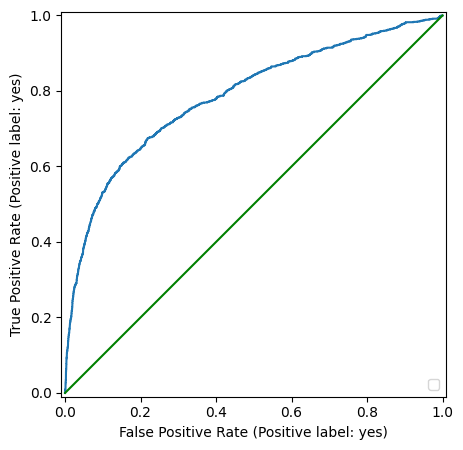

In [104]:
roc_plot(y_test_binary,xgb_y_prob)

Our ROC Curve is visully closer to the left top corner comparedto other models

## Evaluate XGBoost Performance with Precision-Recall Curve

Precision measures the proportion of true positive predictions among all positive predictions, while recall measures the proportion of true positive predictions among all actual positive instances. A high area under the PR curve indicates that the model achieves both high precision and high recall.

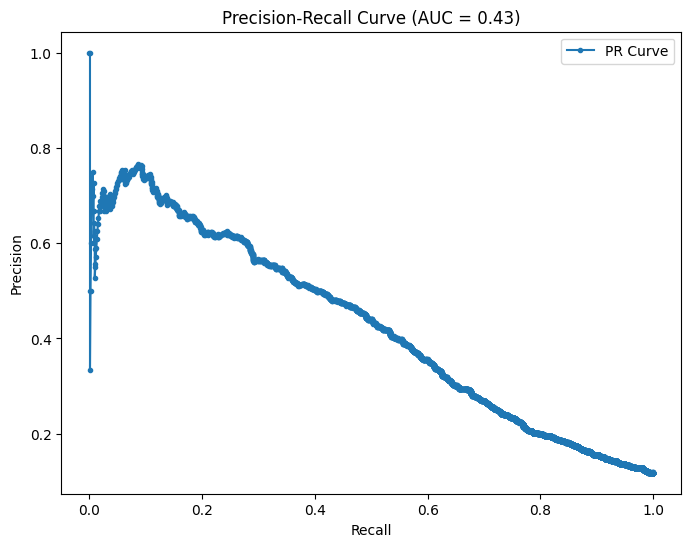

In [105]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision, recall, and thresholds
precision, recall,thresholds = precision_recall_curve(y_test_binary, xgb_y_prob)

# Calculate the area under the PR curve
auc_score = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.legend()
plt.show()

1. Starts with very high precision (~1.0) at low recall, which is expected — the model is confident in a few predictions.

    As recall increases (trying to find more positives), precision drops.

    This curve gradually declines, which is typical — the more positives you try to capture, the more false positives you get.

2. AUC (Average Precision) ≈ 0.43

    This means that on average, your model achieves a precision of 43% across all recall levels.

# Compare metrics across all models

In [107]:
models = [best_lgr, best_dtr,best_rf, best_knn, svc_adj]

for model in models:
  evaluate_model(model, X_train, y_train_, x_test_prep, y_test)

Model: LogisticRegression
Accuracy 0.7467654539422758
F1 Score 0.3694933920704846
Classification report:
              precision    recall  f1-score   support

          no       0.94      0.76      0.84      7976
         yes       0.26      0.63      0.37      1067

    accuracy                           0.75      9043
   macro avg       0.60      0.70      0.61      9043
weighted avg       0.86      0.75      0.79      9043

Confusion Matrix:
[[6082 1894]
 [ 396  671]]
Model: DecisionTreeClassifier
Accuracy 0.5194072763463452
F1 Score 0.2028613352898019
Classification report:
              precision    recall  f1-score   support

          no       0.89      0.52      0.66      7976
         yes       0.13      0.52      0.20      1067

    accuracy                           0.52      9043
   macro avg       0.51      0.52      0.43      9043
weighted avg       0.80      0.52      0.60      9043

Confusion Matrix:
[[4144 3832]
 [ 514  553]]
Model: RandomForestClassifier
Accuracy 0.8

XGBoost

Model: XGBClassifier

Accuracy 0.8894172287957536
\
F1 Score 0.3834771886559803

Classification report:

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7976
           1       0.56      0.29      0.38      1067

    accuracy                           0.89      9043
    macro avg       0.74      0.63      0.66      9043
    weighted avg       0.87      0.89      0.87      9043

    Confusion Matrix:
    [[7732  244]
    [ 756  311]]


# Models Comparison Summary


| Model               | Accuracy  | F1 Score (Positive Class) | Precision (yes) | Recall (yes) |
| ------------------- | --------- | ------------------------- | --------------- | ------------ |
| *Logistic Regression* | 0.747     | 0.369                     | 0.26            | **0.63**         |
| *Decision Tree*       | 0.519     | 0.203                     | 0.13            | 0.52         |
| *Random Forest*      | 0.831     |**0.437**                   | 0.36            | 0.56         |
| *K-Nearest Neighbors* | 0.809     | 0.330                     | 0.28            | 0.40         |
| *Linear SV*C          | 0.749     | 0.372                     | 0.26            | **0.63**         |
| **XGBoost**         | **0.889** | 0.383                | **0.56**        | **0.29**     |


1. *XGBoost* achieved the **highest overall accuracy (88.9%**) and the **best precision (0.56)** for the minority class
2. *Random Fores*t delivered the **best F1 score (0.44)**
3.  *Logistic Regression* and *LinearSVC* had the **highest recall (0.63)**
4. *Decision Tree* significantly underperformed

Based on the evaluation metrics and practical considerations (imbalanced data, skewness of data), the**Random Forest** and **XGBoost classifiers** are the strongest candidates.

* if model interpretability is crucial, $Random Forest$ is preferable

* If performance is the priority, $XGBoost$ is the final choice.

# 🏁 Conclusion
After testing six models, **XGBoost** and **Random Forest** emerged as top performers. XGBoost achieved the highest accuracy (88.9%) and best precision for the positive class, while Random Forest had the best F1 score, balancing precision and recall effectively.

The results show that:

- *Ensemble models*(XGBoost, Random Forest) clearly outperform simpler models.

- *Model performance* must be evaluated beyond accuracy due to data imbalance.

*- F1 score, precision, and recall* offer more meaningful insight when class distribution is skewed.

### 👉 Final recommendation:
XGBoost as the most robust model, ideal for training, evaluation and further tuning.

